In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from Models import mobilenetv2
import sys

middle_size = 4
width = 16
height = 16
normal_para = 6

client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10',
                                                  device='cuda:0',partition=-1)

from Dataloaders import dataloader_cifar10

train, _, val = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)
import torch
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda:0')
client = client.to(device)
server = server.to(device)
client = client.eval()
server = server.eval()

middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)
middle.load_state_dict(torch.load('model_middle_'+str(middle_size)+'.pth'))
middle = middle.to(device)
middle = middle.eval()

from Models import gatedmodel
gate = gatedmodel.GateCNN_v4(input_size=32, width=width, height=height, output_size=1)
gate.load_state_dict(torch.load('mobile_cifar-10_gate_diff_binary_'+str(middle_size)+'.pth'))

gate = gate.to(device)
gate = gate.eval()

# criterion = nn.MSELoss()
# make not equaly distributed distribution
# a^(3*(1/x^3)) * (1/a)^3
optimizer = optim.Adam(gate.parameters(), lr=0.001)

from tqdm import tqdm
from Utils import utils
from torch.nn import functional as F

criterion = torch.nn.BCELoss()

import sys
import torchsummary
epochs = 200
min_val_loss = 1000000
with torch.no_grad():

    val_loss = 0.0
    correct_rate = []
    for i, data in enumerate(val):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = client(inputs)
        outputs_out = middle(outputs)

        target = server(outputs_out)
        target = torch.functional.F.softmax(target, dim=1)
        target = torch.argmax(target, dim=1)

        target2 = server(outputs)
        target2 = torch.functional.F.softmax(target2, dim=1)
        target2 = torch.argmax(target2, dim=1)

        target_diff = torch.eq(target, target2).float()
        target_diff = target_diff.view(-1, 1)
        
        # conf = gate_normal(a=normal_para, x=conf)

        pred = gate(outputs, outputs_out)
        val_loss += criterion(pred, target_diff).item()

        correct_rate.append(torch.sum(target_diff))

    print('val loss: ', val_loss/len(val))
    print('val correct rate: ', correct_rate)
    print('val correct rate mean: ', torch.mean(torch.tensor(correct_rate)))


Files already downloaded and verified
Files already downloaded and verified
val loss:  46.50909810126582
val correct rate:  [tensor(112., device='cuda:0'), tensor(117., device='cuda:0'), tensor(109., device='cuda:0'), tensor(108., device='cuda:0'), tensor(116., device='cuda:0'), tensor(121., device='cuda:0'), tensor(121., device='cuda:0'), tensor(108., device='cuda:0'), tensor(114., device='cuda:0'), tensor(116., device='cuda:0'), tensor(112., device='cuda:0'), tensor(112., device='cuda:0'), tensor(112., device='cuda:0'), tensor(119., device='cuda:0'), tensor(105., device='cuda:0'), tensor(115., device='cuda:0'), tensor(115., device='cuda:0'), tensor(117., device='cuda:0'), tensor(117., device='cuda:0'), tensor(120., device='cuda:0'), tensor(117., device='cuda:0'), tensor(115., device='cuda:0'), tensor(108., device='cuda:0'), tensor(114., device='cuda:0'), tensor(113., device='cuda:0'), tensor(116., device='cuda:0'), tensor(113., device='cuda:0'), tensor(113., device='cuda:0'), tensor(

Files already downloaded and verified
Files already downloaded and verified


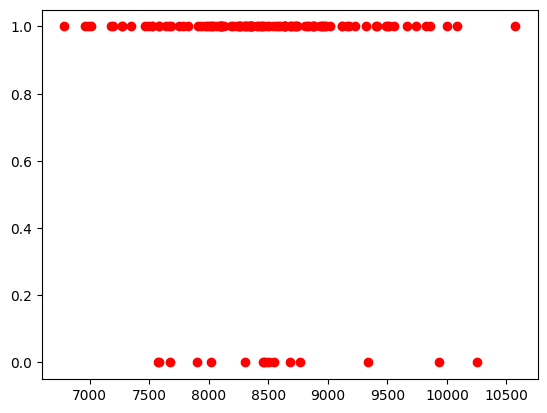

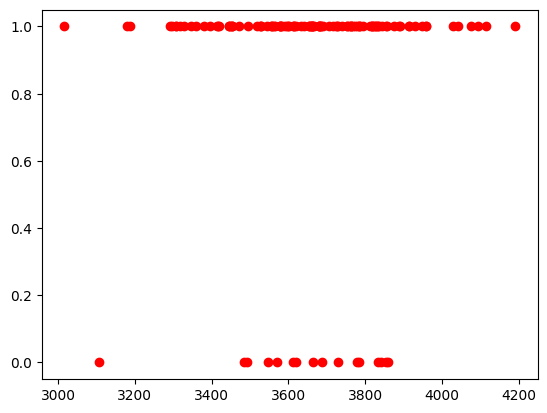

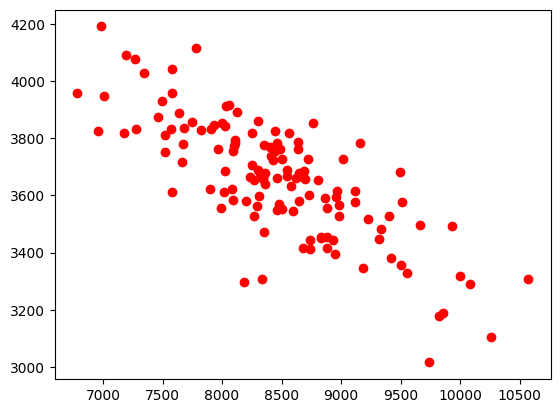

In [24]:
# import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from Models import mobilenetv2
import sys

middle_size = 4
width = 16
height = 16
normal_para = 6

client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10',
                                                  device='cuda:0',partition=-1)

from Dataloaders import dataloader_cifar10

train, _, val = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)
import torch
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda:0')
client = client.to(device)
server = server.to(device)
client = client.eval()
server = server.eval()

middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)
middle.load_state_dict(torch.load('model_middle_'+str(middle_size)+'.pth'))
middle = middle.to(device)
middle = middle.eval()

from Models import gatedmodel
gate = gatedmodel.GateCNN_v5(input_size=32, width=width, height=height, output_size=1)
gate.load_state_dict(torch.load('mobile_cifar-10_gate_diff_binary_'+str(middle_size)+'.pth'))

gate = gate.to(device)
gate = gate.eval()

# criterion = nn.MSELoss()
# make not equaly distributed distribution
# a^(3*(1/x^3)) * (1/a)^3
optimizer = optim.Adam(gate.parameters(), lr=0.001)

from tqdm import tqdm
from Utils import utils
from torch.nn import functional as F

criterion = torch.nn.BCELoss()

import sys
import torchsummary
epochs = 200
min_val_loss = 1000000
with torch.no_grad():

    val_loss = 0.0
    emb_diff = []
    emb_diff2 = []
    acc_diff = []
    for i, data in enumerate(val):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = client(inputs)
        outputs_client = outputs.clone()
        outputs_out = middle(outputs)
        outputs_client_out = outputs_out.clone()

        # low accy output
        # normalized output
        out_max = torch.max(outputs_out, dim=1)
        out_min = torch.min(outputs_out, dim=1)
        
        # normalize each picture
        for i in range(outputs_out.size(0)):
            outputs[i] = (outputs[i] - out_min.values[i]) / (out_max.values[i] - out_min.values[i])
            outputs_out[i] = (outputs_out[i] - out_min.values[i]) / (out_max.values[i] - out_min.values[i])

        # times 32 and change to int
        outputs = outputs * 8
        outputs_out = outputs_out * 8
        outputs = outputs.int()
        outputs_out = outputs_out.int()

        emb_diff = torch.abs(outputs - outputs_out)
        emb_diff = torch.sum(emb_diff, dim=(1,2,3))
        emb_diff2 = torch.eq(outputs, outputs_out)
        emb_diff2 = torch.sum(emb_diff2, dim=(1,2,3))

        pred = server(outputs_client)
        pred_out = server(outputs_client_out)

        target = torch.functional.F.softmax(pred, dim=1)
        target = torch.argmax(target, dim=1)

        target2 = torch.functional.F.softmax(pred_out, dim=1)
        target2 = torch.argmax(target2, dim=1)

        acc_diff = torch.eq(target, target2)

        break

import matplotlib.pyplot as plt
import numpy as np

emb_diff = emb_diff.cpu().numpy()
emb_diff2 = emb_diff2.cpu().numpy()
acc_diff = acc_diff.cpu().numpy()
plt.plot(emb_diff, acc_diff, 'ro')
plt.show()
plt.plot(emb_diff2, acc_diff, 'ro')
plt.show()
plt.plot(emb_diff, emb_diff2, 'ro')
plt.show()


In [48]:
a = torch.tensor([1,2,3,4,5,6,7,8,9,10])
b = torch.tensor([1,2,3,4,5,6,7,8,9,10])
# pixal wise product
c = a * b
torch.eq(a, b)

tensor([True, True, True, True, True, True, True, True, True, True])

In [12]:
from Models import mobilenetv2
middle_size = 4
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10, weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10', device='cuda:0', partition=-1)
import torch
from Models import gatedmodel
gate = gatedmodel.GateCNN_v5(input_size=32, width=16, height=16, output_size=1)
middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)
gate.load_state_dict(torch.load('mobile_cifar-10_gate_diff_binary_'+str(middle_size)+'.pth'))
middle.load_state_dict(torch.load('model_middle_'+str(middle_size)+'.pth'))

client = client.eval()
server = server.eval()
gate = gate.eval()
middle = middle.eval()

client = client.to('cuda:0')
server = server.to('cuda:0')
gate = gate.to('cuda:0')
middle = middle.to('cuda:0')

from Dataloaders import dataloader_cifar10
train, _, val = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)

for i, data in enumerate(val):
    inputs, labels = data
    inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
    outputs = client(inputs)
    outputs_out = middle(outputs)
    outputs_diff = outputs - outputs_out
    pred = gate(outputs_diff)
    print(pred)
                                                

Files already downloaded and verified
Files already downloaded and verified
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],


In [18]:
# Copyright (c) 2021 Qualcomm Technologies, Inc.
# All Rights Reserved.


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class MaxPooling(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        x = torch.cat((x.unsqueeze(dim=1), y.unsqueeze(dim=1)), dim=1)

        return x.max(dim=1)[0]


def execute_exiting(func, out_ave, pre_exit_features=None):
    if pre_exit_features is not None:
        exit_door_val = func(out_ave, prev_features=pre_exit_features[-1])
    else:
        exit_door_val = func(out_ave)

    return exit_door_val


class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, num_neurons=4096):
        super().__init__()
        self.input_dim = input_dim
        self.num_neurons = [num_neurons]

        layers = []
        dim_input = input_dim
        for dim_output in self.num_neurons:
            layers.append(nn.Linear(dim_input, dim_output))
            layers.append(nn.BatchNorm1d(dim_output))
            layers.append(nn.ReLU())
            dim_input = dim_output

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)

        return x


def get_torchvision_model(
    name, pretrained=True, requires_grad=False, truncate_modules=None
):
    torchvision_models = models
    if "." in name:
        prefix, name = name.split(".")[0], name.split(".")[1]
        assert prefix in vars(torchvision_models).keys()
        torchvision_models = vars(torchvision_models)[prefix]
    assert name in vars(torchvision_models).keys()

    if name == "inception_v3":
        model = vars(torchvision_models)[name](pretrained=pretrained, aux_logits=False)
    else:
        model = vars(torchvision_models)[name](pretrained=pretrained)
    if truncate_modules is not None:
        model = torch.nn.Sequential(*list(model.children())[:truncate_modules])
    for param in model.parameters():
        param.requires_grad = requires_grad

    if not requires_grad:
        model.eval()

    return model


def get_base_model(name, config):
    truncate_modules = (
        config.model.backbone.truncate_modules
        if config.model.backbone.get("truncate_modules")
        else None
    )
    if name is None:
        return None
    if "torchvision" in name.lower():
        model_name = name.split(".", 1)[-1]
        model = get_torchvision_model(
            name=model_name,
            pretrained=config.model.backbone.pretrained,
            requires_grad=config.model.backbone.requires_grad,
            truncate_modules=truncate_modules,
        )
    else:
        raise Exception("couldn't find %s as a model name" % name)

    return model


class ExitingGate(nn.Module):
    def __init__(self, in_planes):
        super(ExitingGate, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, 128, kernel_size=1, stride=1, bias=True)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=1, stride=1, bias=True)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(128, 1, bias=True)

    def forward(self, x, force_hard=True, prev_features=None):
        x0, x1 = x[0], x[1]
        x0 = F.relu(self.bn1(self.conv1(x0)))
        x0 = F.relu(self.bn2(self.conv2(x0)))
        x0 = torch.flatten(x0, 1)
        x1 = F.relu(self.bn1(self.conv1(x1)))
        x1 = F.relu(self.bn2(self.conv2(x1)))
        x1 = torch.flatten(x1, 1)
        x = torch.cat([x0, x1], dim=1)
        out = self.linear(x)
        out = self.sigmoid(out)
        out[out >= 0.5] = 1
        out[out < 0.5] = 0

        return out


class AdaptiveBase(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.backbone_type = config.model.backbone.type
        self.backbone_name = config.model.backbone.name

        # base model
        self.backbone = get_base_model(config.model.backbone.name, config)
        model_output_dim = config.model.backbone.output_dim

        # fully connected layer
        num_neurons = 4096
        self.mlp = MultiLayerPerceptron(
            input_dim=model_output_dim, num_neurons=num_neurons
        )
        self.model_output_dim = num_neurons

        self.avg_pool_2d = nn.AdaptiveAvgPool2d((1, 1))  # in case of frame as input
        self.num_frames = config.data.num_frames

    def forward(self, x):
        b = x.size(0)
        seq_len = x.size(1)

        # Mix batch and T
        x = x.view((b * seq_len,) + x.size()[2:])

        x = self.backbone(x)

        # separate batch and T
        if len(x.shape) > 2:
            x = self.avg_pool_2d(x)  # remove spatial dim
        x = x.view(
            (
                b,
                seq_len,
            )
            + x.size()[1:]
        )
        x = x.flatten(start_dim=2)

        # fc layer
        x = x.view(b * seq_len, np.prod(x.size()[2:]))
        x = self.mlp(x)
        x = x.view(b, seq_len, -1)

        return x


def threshold_selection(y_t, threshold=0.99):
    y_t_probs = torch.nn.Softmax(dim=1)(y_t)
    exit_door = torch.max(y_t_probs, dim=1)[0] > threshold

    return False if exit_door[0] == 0 else True


class ConditionalFrameExitInferenceModel():
    def __init__(self):
        super().__init__()
        self.num_frames = 60
        self.num_class = 10
        self.first_threshold = 0.8
        self.max_pooling = MaxPooling()
        self.exit_selector = nn.ModuleList()
        self.exit_door = None
        self.exited_classifiers = None
        self.classifiers = nn.ModuleList()
        for m in range(self.num_frames):
            self.classifiers.append(nn.Linear(self.model_output_dim, self.num_class))
            if m > 0:
                self.exit_selector.append(ExitingGate(4096))

    def gate_selection(self, idx, y_t):
        exit_door = execute_exiting(self.exit_selector[idx], y_t)

        return True if exit_door[0] == 0 else False

    def forward(self, x, z_previous=None, t=torch.tensor(0)):
        y_t = None
        z_t = super().forward(x)
        z_t = z_t.squeeze(dim=1)
        b = z_t.shape[0]
        self.exit_door = torch.zeros(
            [x.shape[0], len(self.classifiers)], device=x.device
        )
        if t > 0:
            z_t = self.max_pooling.forward(z_t, z_previous)

        # for the first frame, we use a simple confidence threshold to exit
        if t == 0:
            z_t = torch.flatten(z_t, start_dim=1)
            y_t = self.classifiers[t](z_t)
            exited = threshold_selection(y_t, threshold=self.first_threshold)
        elif t < self.num_frames - 1:
            exited = self.gate_selection(
                t - 1, [z_t.view(b, -1, 1, 1), z_previous.view(b, -1, 1, 1)]
            )
        else:
            exited = True

        if exited:
            if t > 0:
                z_t = torch.flatten(z_t, start_dim=1)
                y_t = self.classifiers[t](z_t)
            self.exited_classifiers = t + 1
            self.exit_door[0][t] = 1
            return y_t, None
        else:
            return None, z_t


In [19]:
classifiers = nn.ModuleList()
exit_selector = nn.ModuleList()
for m in range(60):
    classifiers.append(nn.Linear(60, 10))
    if m > 0:
        exit_selector.append(ExitingGate(4096))

In [29]:
from Models import mobilenetv2
middle_size = 4
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10, weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10', device='cuda:0', partition=-1)
import torch
from Models import gatedmodel
# gate1 = gatedmodel.GateCNN_v5(input_size=32, width=16, height=16, output_size=1)
# middle1 = mobilenetv2.MobileNetV2_middle(middle=1)
# # gate.load_state_dict(torch.load('mobile_cifar-10_gate_diff_binary_'+str(middle_size)+'.pth'))
# middle1.load_state_dict(torch.load('model_middle_'+str(1)+'.pth'))

# middle2 = mobilenetv2.MobileNetV2_middle(middle=2)
# middle2.load_state_dict(torch.load('model_middle_'+str(2)+'.pth'))

# middle3 = mobilenetv2.MobileNetV2_middle(middle=4)
# middle3.load_state_dict(torch.load('model_middle_'+str(4)+'.pth'))

# middle4 = mobilenetv2.MobileNetV2_middle(middle=8)
# middle4.load_state_dict(torch.load('model_middle_'+str(8)+'.pth'))

middle_ns = []
for i in range(1, 9):
    middle = mobilenetv2.MobileNetV2_middle(middle=i)
    middle.load_state_dict(torch.load('model_middle_'+str(i)+'.pth'))
    middle_ns.append(middle)

client = client.eval()
server = server.eval()
gate = gate.eval()
# middle1 = middle1.eval()
# middle2 = middle2.eval()
# middle3 = middle3.eval()
# middle4 = middle4.eval()
for middle in middle_ns:
    middle = middle.eval()
    middle = middle.to('cuda:0')

client = client.to('cuda:0')
server = server.to('cuda:0')
gate = gate.to('cuda:0')
# middle1 = middle1.to('cuda:0')
# middle2 = middle2.to('cuda:0')
# middle3 = middle3.to('cuda:0')
# middle4 = middle4.to('cuda:0')

from Dataloaders import dataloader_cifar10
train, _, val = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)

for i, data in enumerate(val):
    inputs, labels = data
    inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
    outputs = client(inputs).detach()

    out = []
    for j in range(8):
        out.append(middle_ns[j].in_layer(outputs))
        out[j] = out[j] * 255
        out[j] = out[j].int()
        out[j] = out[j].float()
        out[j] = out[j] / 255
        out[j] = middle_ns[j].out_layer(out[j])
    out.insert(0, outputs)

    mse_mat = torch.zeros((9, 9))
    for j in range(9):
        for k in range(9):
            mse_mat[j][k] = torch.nn.L1Loss()(out[k], out[j]).item()
    
    print(mse_mat)
    break

                                                

Files already downloaded and verified
Files already downloaded and verified
tensor([[0.0000, 0.4195, 0.3432, 0.2740, 0.2416, 0.2601, 0.1904, 0.1799, 0.2431],
        [0.4195, 0.0000, 0.3912, 0.4012, 0.4249, 0.4063, 0.4050, 0.4007, 0.4164],
        [0.3432, 0.3912, 0.0000, 0.3455, 0.3425, 0.3170, 0.3363, 0.3320, 0.3601],
        [0.2740, 0.4012, 0.3455, 0.0000, 0.2930, 0.2382, 0.2512, 0.2610, 0.2486],
        [0.2416, 0.4249, 0.3425, 0.2930, 0.0000, 0.2181, 0.2387, 0.2317, 0.2197],
        [0.2601, 0.4063, 0.3170, 0.2382, 0.2181, 0.0000, 0.2303, 0.2287, 0.2089],
        [0.1904, 0.4050, 0.3363, 0.2512, 0.2387, 0.2303, 0.0000, 0.1652, 0.2165],
        [0.1799, 0.4007, 0.3320, 0.2610, 0.2317, 0.2287, 0.1652, 0.0000, 0.2275],
        [0.2431, 0.4164, 0.3601, 0.2486, 0.2197, 0.2089, 0.2165, 0.2275, 0.0000]])


In [35]:
import pandas as pd
import numpy as np

# create a blank pd
conf_diff_pd = pd.DataFrame([], columns=['diff', 'gate'])

In [40]:
from Models import mobilenetv2
middle_size = 4
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10, weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10', device='cuda:0', partition=-1)
import torch
from Models import gatedmodel
# gate1 = gatedmodel.GateCNN_v5(input_size=32, width=16, height=16, output_size=1)
# middle1 = mobilenetv2.MobileNetV2_middle(middle=1)
# # gate.load_state_dict(torch.load('mobile_cifar-10_gate_diff_binary_'+str(middle_size)+'.pth'))
# middle1.load_state_dict(torch.load('model_middle_'+str(1)+'.pth'))

# middle2 = mobilenetv2.MobileNetV2_middle(middle=2)
# middle2.load_state_dict(torch.load('model_middle_'+str(2)+'.pth'))

# middle3 = mobilenetv2.MobileNetV2_middle(middle=4)
# middle3.load_state_dict(torch.load('model_middle_'+str(4)+'.pth'))

# middle4 = mobilenetv2.MobileNetV2_middle(middle=8)
# middle4.load_state_dict(torch.load('model_middle_'+str(8)+'.pth'))

middle_ns = []
for i in range(1, 9):
    middle = mobilenetv2.MobileNetV2_middle(middle=i)
    middle.load_state_dict(torch.load('model_middle_'+str(i)+'.pth'))
    middle_ns.append(middle)

client = client.eval()
server = server.eval()
# gate = gate.eval()
# middle1 = middle1.eval()
# middle2 = middle2.eval()
# middle3 = middle3.eval()
# middle4 = middle4.eval()
for middle in middle_ns:
    middle = middle.eval()
    middle = middle.to('cuda:0')

client = client.to('cuda:0')
server = server.to('cuda:0')
# gate = gate.to('cuda:0')
# middle1 = middle1.to('cuda:0')
# middle2 = middle2.to('cuda:0')
# middle3 = middle3.to('cuda:0')
# middle4 = middle4.to('cuda:0')

from Dataloaders import dataloader_cifar10
train, _, val = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)

import pandas as pd
from tqdm import tqdm
conf_diff_pd = pd.DataFrame([], columns=['img', 'diff', 'current gate'])
count = 0
for i, data in enumerate(tqdm(val)):
    inputs, labels = data
    inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
    outputs = client(inputs).detach()

    out = []
    for j in range(8):
        out.append(middle_ns[j].in_layer(outputs))
        out[j] = out[j] * 255
        out[j] = out[j].int()
        out[j] = out[j].float()
        out[j] = out[j] / 255
        out[j] = middle_ns[j].out_layer(out[j])
    out.append(outputs)

    conf = []
    for j in range(9):
        conf.append(server(out[j]))
        conf[j] = torch.functional.F.softmax(conf[j], dim=1)
        # the conf and the target 
        conf[j] = conf[j].gather(1, labels.view(-1, 1))
        conf[j] = conf[j].detach().cpu()
    
    for j in range(9-1):
        for k in range(conf[j].size(0)):
            conf_diff = (conf[j][k] - conf[-1][k]).item()
            # add it to the pandas
            conf_diff_pd = pd.concat([conf_diff_pd, pd.DataFrame([[str(count + k), float(conf_diff), str(j)]], columns=['img', 'diff', 'current gate'])], ignore_index=True)
    count += inputs.size(0)
print(conf_diff_pd)                             


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_994706/2951535117.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  conf_diff_pd = pd.concat([conf_diff_pd, pd.DataFrame([[str(count + k), float(conf_diff), str(j)]], columns=['img', 'diff', 'current gate'])], ignore_index=True)
100%|██████████| 79/79 [00:42<00:00,  1.86it/s]

        img      diff current gate
0         0 -0.002969            0
1         1 -0.202779            0
2         2  0.000140            0
3         3 -0.070556            0
4         4 -0.755627            0
...     ...       ...          ...
79995  9995  0.000191            7
79996  9996  0.270484            7
79997  9997  0.000249            7
79998  9998 -0.003970            7
79999  9999  0.000390            7

[80000 rows x 3 columns]


[Text(0.5, 1.0, 'conf diff between gate i and w/o gate')]

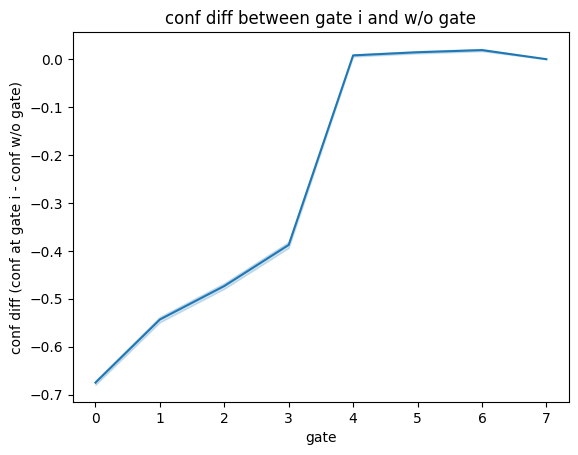

In [57]:
import seaborn as sns

chart = sns.lineplot(x="current gate", y="diff", data=conf_diff_pd)
chart.set(ylabel='conf diff (conf at gate i - conf w/o gate)', xlabel='gate')
chart.set(title='conf diff between gate i and w/o gate')


In [39]:
conf_diff_pd.loc[conf_diff_pd['current gate'] == str(0)]
print(np.max(conf_diff_pd['diff']))
print(np.min(conf_diff_pd['diff']))

0.9803719520568848
-0.9988831877708435


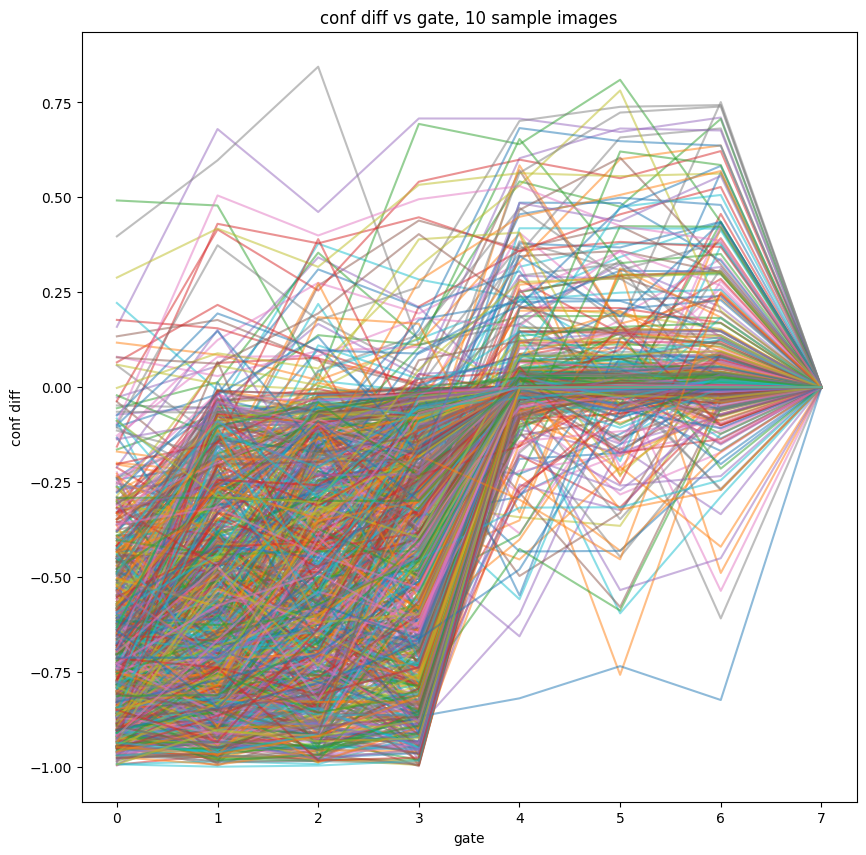

In [58]:
# get 10 images and plot the conf diff vs gate
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 10))
for i in range(1000):
    img = conf_diff_pd.loc[conf_diff_pd['img'] == str(i)]
    plt.plot(img['current gate'], img['diff'], alpha=0.5)
    plt.xlabel('gate')
    plt.ylabel('conf diff')
    plt.title('conf diff vs gate, 10 sample images')
plt.show()

In [47]:
from Models import resnet
middle_size = 4
client, server = resnet.resnet_splitter(num_classes=10, weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10', 
                                        device='cuda:0', partition=-1,
                                        layers=50)
import torch
from Models import gatedmodel
# gate1 = gatedmodel.GateCNN_v5(input_size=32, width=16, height=16, output_size=1)
# middle1 = mobilenetv2.MobileNetV2_middle(middle=1)
# # gate.load_state_dict(torch.load('mobile_cifar-10_gate_diff_binary_'+str(middle_size)+'.pth'))
# middle1.load_state_dict(torch.load('model_middle_'+str(1)+'.pth'))

# middle2 = mobilenetv2.MobileNetV2_middle(middle=2)
# middle2.load_state_dict(torch.load('model_middle_'+str(2)+'.pth'))

# middle3 = mobilenetv2.MobileNetV2_middle(middle=4)
# middle3.load_state_dict(torch.load('model_middle_'+str(4)+'.pth'))

# middle4 = mobilenetv2.MobileNetV2_middle(middle=8)
# middle4.load_state_dict(torch.load('model_middle_'+str(8)+'.pth'))

middle_ns = []
for i in range(7):
    middle = resnet.resnet_middle(middle=2**i)
    middle.load_state_dict(torch.load('resnet_cifar-10_middle_'+str(2**i)+'.pth'))
    middle_ns.append(middle)

client = client.eval()
server = server.eval()
# gate = gate.eval()
# middle1 = middle1.eval()
# middle2 = middle2.eval()
# middle3 = middle3.eval()
# middle4 = middle4.eval()
for middle in middle_ns:
    middle = middle.eval()
    middle = middle.to('cuda:0')

client = client.to('cuda:0')
server = server.to('cuda:0')
# gate = gate.to('cuda:0')
# middle1 = middle1.to('cuda:0')
# middle2 = middle2.to('cuda:0')
# middle3 = middle3.to('cuda:0')
# middle4 = middle4.to('cuda:0')

from Dataloaders import dataloader_cifar10
train, _, val = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)

import pandas as pd
from tqdm import tqdm
conf_diff_pd = pd.DataFrame([], columns=['img', 'diff', 'current gate'])
count = 0
for i, data in enumerate(tqdm(val)):
    inputs, labels = data
    inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
    outputs = client(inputs).detach()

    out = []
    for j in range(7):
        out.append(middle_ns[j].in_layer(outputs))
        out[j] = out[j] * 255
        out[j] = out[j].int()
        out[j] = out[j].float()
        out[j] = out[j] / 255
        out[j] = middle_ns[j].out_layer(out[j])
    out.append(outputs)

    conf = []
    for j in range(8):
        conf.append(server(out[j]))
        conf[j] = torch.functional.F.softmax(conf[j], dim=1)
        # the conf and the target 
        conf[j] = conf[j].gather(1, labels.view(-1, 1))
        conf[j] = conf[j].detach().cpu()
    
    for j in range(9-1):
        for k in range(conf[j].size(0)):
            conf_diff = (conf[j][k] - conf[-1][k]).item()
            # add it to the pandas
            conf_diff_pd = pd.concat([conf_diff_pd, pd.DataFrame([[str(count + k), float(conf_diff), str(j)]], columns=['img', 'diff', 'current gate'])], ignore_index=True)
    count += inputs.size(0)
print(conf_diff_pd)                             


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_994706/700278455.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  conf_diff_pd = pd.concat([conf_diff_pd, pd.DataFrame([[str(count + k), float(conf_diff), str(j)]], columns=['img', 'diff', 'current gate'])], ignore_index=True)
100%|██████████| 79/79 [00:45<00:00,  1.75it/s]

        img      diff current gate
0         0 -0.831971            0
1         1 -0.845247            0
2         2 -0.744183            0
3         3 -0.890109            0
4         4 -0.547397            0
...     ...       ...          ...
79995  9995  0.000000            7
79996  9996  0.000000            7
79997  9997  0.000000            7
79998  9998  0.000000            7
79999  9999  0.000000            7

[80000 rows x 3 columns]


[Text(0.5, 1.0, 'conf diff between gate i and w/o gate Resnet')]

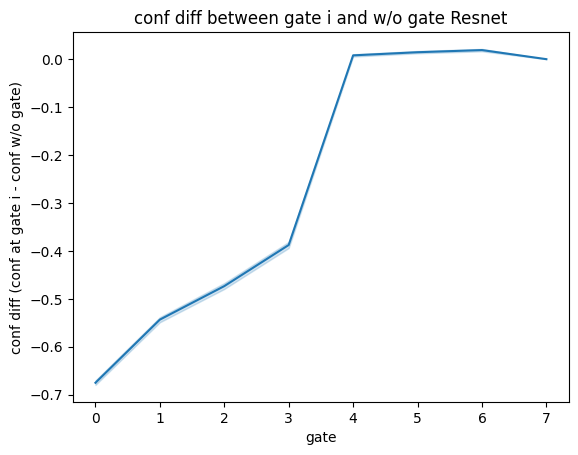

In [56]:
import seaborn as sns

chart = sns.lineplot(x="current gate", y="diff", data=conf_diff_pd)
chart.set(ylabel='conf diff (conf at gate i - conf w/o gate)', xlabel='gate')
chart.set(title='conf diff between gate i and w/o gate Resnet')

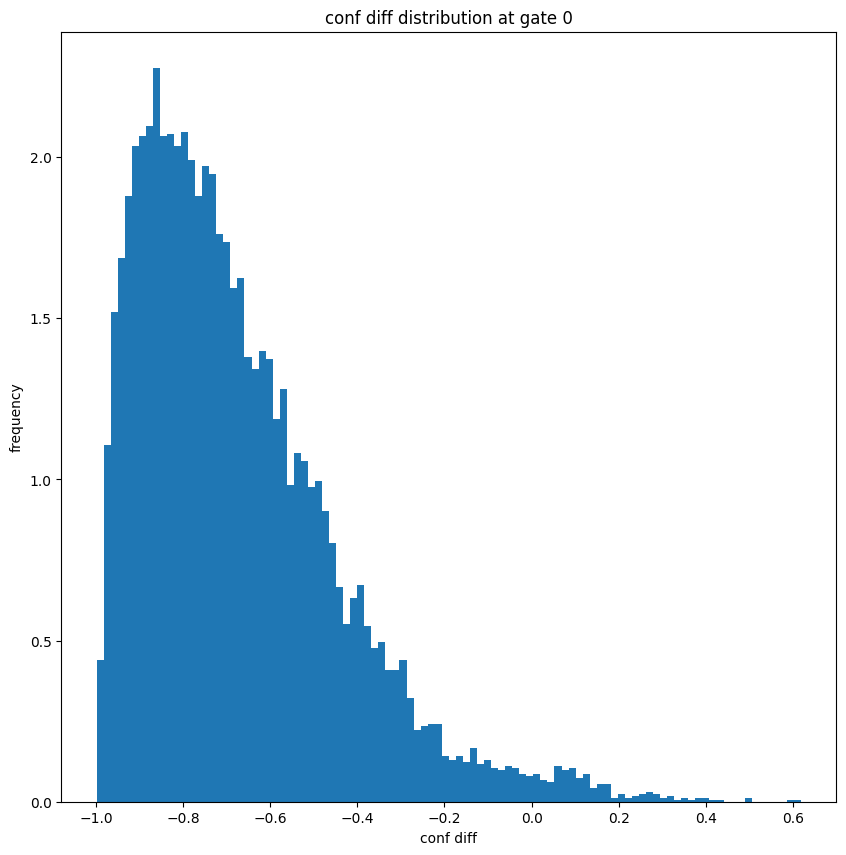

In [55]:
# plot the distribute of the conf diff at gate 0
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 10))
img = conf_diff_pd.loc[conf_diff_pd['current gate'] == str(0)]
plt.hist(img['diff'], bins=100, cumulative=False, density=True)
plt.xlabel('conf diff')
plt.ylabel('frequency')
plt.title('conf diff distribution at gate 0')
plt.show()